# Adtracking Fraud Detection

by Kyle O'Brien, Catherine Lee, Amit Saxena 

Data is in "data/" and includes the training and testing csv files.
Evaluation metrics will include looking at R^2 and a confusion matrix. Other things to try, CNN (Resnet, inceptionv3)

In [1]:
import numpy as np         # linear algebra
import sklearn as sk       # machine learning
import pandas as pd        # reading in data files, data cleaning
import matplotlib.pyplot as plt   # for plotting
import seaborn as sns      # visualization tool
import tensorflow as tf
import keras

Using TensorFlow backend.


Train_sample: 100,000 randomly-selected rows of training data (because the full training data takes too long)

In [8]:
#load data in 

data = pd.read_csv("data/equalized_train.csv")

data.head()


,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83252,3,1,16,379,2017-11-06 15:42:19,NaN,0
1,106590,3,1,25,379,2017-11-06 15:43:23,NaN,0
2,147164,14,1,28,134,2017-11-06 16:00:00,NaN,0
3,39782,2,1,10,205,2017-11-06 16:00:00,NaN,0
4,121646,23,1,13,153,2017-11-06 16:00:00,NaN,0


In [3]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
ip                 100000 non-null int64
app                100000 non-null int64
device             100000 non-null int64
os                 100000 non-null int64
channel            100000 non-null int64
click_time         100000 non-null object
attributed_time    227 non-null object
is_attributed      100000 non-null int64
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


Dropping attributed_time because many null values

# Feature Engineering for Date and Time

In [4]:
#separate click_time into multiple columns
#data['click_time'].split(" ")


# Understanding our Dataset

In [5]:
#data = data.drop(columns=['attributed_time'])
#data.info()

In [6]:
data['is_attributed'].describe()

count    100000.000000
mean          0.002270
std           0.047591
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: is_attributed, dtype: float64

In [22]:
#plotx = data['attributed_time']
#ploty = data['is_attributed']

#plt.scatter(plotx,ploty)
import pandas
class_counts = data.groupby('is_attributed').size()
print(class_counts)

is_attributed
0    50000
1    41473
dtype: int64


This confirms that we have a major imbalance in our data. This is incentivising our model to guess 0 for overthing and it would still receive a 99% accuracy

# Logistic Regression

In [9]:
X = data[['app', 'device', 'os', 'channel']]
y = data['is_attributed']

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [11]:
X_train.head()

,app,device,os,channel
22243,2,1,20,477
58933,105,1,17,451
50574,18,3032,607,107
63812,11,1,13,325
52847,116,1,41,101


In [12]:
y_train.head()

22243    0
58933    1
50574    0
63812    1
52847    1
Name: is_attributed, dtype: int64

In [13]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [14]:
logreg.fit(X_train, y_train)


/root/.local/share/virtualenvs/fraud_detection-yH1T5P0u/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [15]:
predictions = logreg.predict(X_test)

Seems a little strange that we would get such high accuracy. This might have to do with the fact that we are using R^2 to measure the goodness of our model. There might be an imbalance in the test set of which clicks are 0 or 1, so we should try precision and recall. (Longterm with full training data, try to keep an equal number of classes)

In [43]:
logreg_score = logreg.score(X_test, y_test)
print("Logistic Regression Accuracy", logreg_score)

Logistic Regression Accuracy 0.6349822355834928


# Random forest

In [40]:
from sklearn.ensemble import RandomForestClassifier
RandomForest = RandomForestClassifier()
RandomForest.fit(X_train,y_train)
rf_score = RandomForest.score(X_test,y_test)
print("Random Forest accuracy:", rf_score)

/root/.local/share/virtualenvs/fraud_detection-yH1T5P0u/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest accuracy: 0.9335337523913637


In [37]:
# Precision Recall Score
from sklearn.metrics import classification_report

y_pred = RandomForest.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      9971
           1       0.96      0.89      0.92      8324

   micro avg       0.93      0.93      0.93     18295
   macro avg       0.94      0.93      0.93     18295
weighted avg       0.93      0.93      0.93     18295



# Support Vector Machine

In [17]:
from sklearn.svm import LinearSVC 

In [18]:
lSVC = LinearSVC()

In [41]:
lSVC.fit(X_train,y_train)
svm_score = lSVC.score(X_test,y_test)
print("SVM accuracy:", svm_score)

SVM accuracy: 0.711451216179284


/root/.local/share/virtualenvs/fraud_detection-yH1T5P0u/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# Decision Tree

In [39]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier()

dtc = dtc.fit(X_train,y_train)
dtc_score =  dtc.score(X_test,y_test)
print("Decision Tree Accuracy:", dtc_score)

Decision Tree Accuracy: 0.9352282044274391


In [28]:
# Precision Recall Score
from sklearn.metrics import classification_report

y_pred = dtc.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      9971
           1       0.96      0.89      0.93      8324

   micro avg       0.94      0.94      0.94     18295
   macro avg       0.94      0.93      0.93     18295
weighted avg       0.94      0.94      0.93     18295



[[9689  282]
 [ 904 7420]]


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

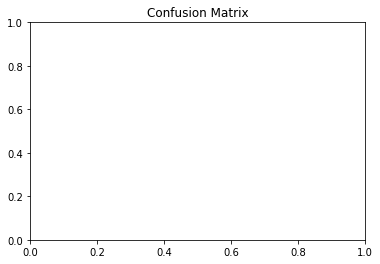

In [32]:
# Confusion Matrix

#In Progress

from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))
plt.title("Confusion Matrix")

plt.colorbar()
tick_marks = np.arange(2)


# Which model do we use?

In [44]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Logistic Regression', 
              'Random Forest', 'Linear SVC', 
              'Decision Tree'],
    'Score': [svm_score, logreg_score, rf_score, svm_score, dtc_score]})
models.sort_values(by='Score', ascending=False)

,Model,Score
4,Decision Tree,0.935228
2,Random Forest,0.933534
0,Support Vector Machines,0.711451
3,Linear SVC,0.711451
1,Logistic Regression,0.634982


# Neural Network

In [ ]:
model = Sequential()
model.add(Dense(500, activation='sigmoid', input_dim = 13))
model.add(Dense(400,activation='sigmoid'))
model.add(Dense(200, activation='sigmoid'))

model.compile(optimizer = 'rmsprop',     
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])



# XGBoost

# Ensemble Learning